In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

sys.path.append("..")

from shift_detector import *
from shift_reductor import *
from shift_experiments import *
from shift_explainer import *
from shift_tester import *
from shift_utils import *
from shift_models import *
from shift_constants import *
from shift_plot_utils import *

sys.path.append("../..")

import sqlalchemy
from sqlalchemy import select, func, extract, desc
from sqlalchemy.sql.expression import and_

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

import config
import cyclops
from cyclops.processors.column_names import (
    ENCOUNTER_ID,
    HOSPITAL_ID,
    ADMIT_TIMESTAMP,
    DISCHARGE_TIMESTAMP,
    DISCHARGE_DISPOSITION,
    READMISSION,
    AGE,
    SEX,
    TOTAL_COST,
    CITY,
    PROVINCE,
    COUNTRY,
    LANGUAGE,
    LENGTH_OF_STAY_IN_ER,
    VITAL_MEASUREMENT_NAME,
    VITAL_MEASUREMENT_VALUE,
    VITAL_MEASUREMENT_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE,
)
from cyclops.processors.constants import EMPTY_STRING
from cyclops.processors.admin import AdminProcessor
from cyclops.processors.vitals import VitalsProcessor
from cyclops.processors.labs import LabsProcessor
from cyclops.processors.outcomes import OutcomesProcessor
from cyclops.processors.feature_handler import FeatureHandler
from cyclops.orm import Database

%reload_ext autoreload
%reload_ext nb_black

2022-04-21 22:11:13.451413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.4/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-04-21 22:11:13.451490: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-21 22:11:16.452492: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-21 22:11:16.452571: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cpu1.gemini-hpc.ca): /proc/driver/nvidia/version does not exist
2022-04-21 22:11:16.456511: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is 

<IPython.core.display.Javascript object>

In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500, 1000, 2000]
PATH = "/mnt/nfs/project/delirium/drift_exp/"
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
calc_acc = True
SAMPLES = [10, 20, 50, 100, 200, 500, 1000, 2000]
SHIFTS = ["hosp_type", "academic", "community"]
OUTCOMES = ["length_of_stay_in_er", "mortality_in_hospital"]
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW"]
DR_TECHNIQUES = ["NoRed", "SRP", "PCA", "BBSDs_FFNN"]
MD_TESTS = ["MMD", "LK", "LSDD"]

<IPython.core.display.Javascript object>

In [3]:
OUTCOME = input("Select outcome variable: ")
NA_CUTOFF = 0.60

Select outcome variable: length_of_stay_in_er


<IPython.core.display.Javascript object>

In [7]:
# Run shift experiments
if os.path.exists(PATH + "/mean_dr_md_hosptype.pkl"):
    with open(PATH + "/mean_dr_md_hosptype.pkl", "rb") as f:
        mean_dr_md = pickle.load(f)
else:
    mean_dr_md = np.ones(
        (len(SHIFTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

if os.path.exists(PATH + "/std_dr_md_hosptype.pkl"):
    with open(PATH + "/std_dr_md_hosptype.pkl", "rb") as f:
        std_dr_md = pickle.load(f)
else:
    std_dr_md = np.ones(
        (len(SHIFTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

for si, SHIFT in enumerate(SHIFTS):
    for di, DR_TECHNIQUE in enumerate(DR_TECHNIQUES):
        for mi, MD_TEST in enumerate(MD_TESTS):
            if np.any(mean_dr_md[si, di, mi, :] == -1):
                print("{} | {} | {}".format(SHIFT, DR_TECHNIQUE, MD_TEST))
                try:
                    mean_p_vals, std_p_vals = run_shift_experiment(
                        SHIFT,
                        OUTCOME,
                        HOSPITALS,
                        PATH,
                        DR_TECHNIQUE,
                        MD_TEST,
                        SAMPLES,
                        DATASET,
                        SIGN_LEVEL,
                        NA_CUTOFF,
                        RANDOM_RUNS,
                        calc_acc=True,
                    )
                    mean_dr_md[si, di, mi, :] = mean_p_vals
                    std_dr_md[si, di, mi, :] = std_p_vals
                except ValueError as e:
                    print("Value Error")
                    pass

<IPython.core.display.Javascript object>

In [8]:
# Run shift experiments
if not os.path.exists(PATH + "/mean_dr_md_hosptype.pkl"):
    with open(PATH + "/mean_dr_md_hosptype.pkl", "wb") as f:
        pickle.dump(mean_dr_md, f)
if not os.path.exists(PATH + "/std_dr_md_hosptype.pkl"):
    with open(PATH + "/std_dr_md_hosptype.pkl", "wb") as f:
        pickle.dump(std_dr_md, f)

<IPython.core.display.Javascript object>

Select Pre-Processing: NoRed
Select Two-Sample Testing: LSDD


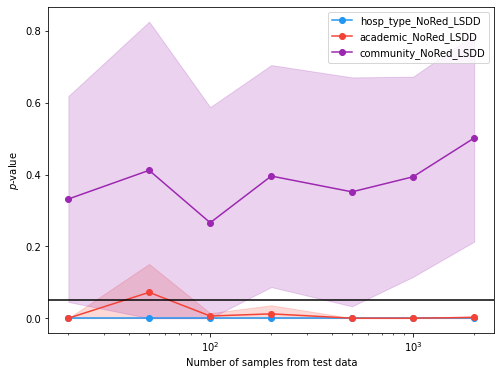

<IPython.core.display.Javascript object>

In [11]:
DIM_RED = input("Select Pre-Processing: ")
MD_TEST = input("Select Two-Sample Testing: ")

fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(SHIFTS):
    for di, dr_technique in enumerate(DR_TECHNIQUES):
        for mi, md_test in enumerate(MD_TESTS):
            if shift in SHIFTS and dr_technique == DIM_RED and md_test == MD_TEST:
                errorfill(
                    np.array(SAMPLES[1:]),
                    mean_dr_md[si, di, mi, 1:],
                    std_dr_md[si, di, mi, 1:],
                    fmt=linestyles[di] + markers[di],
                    color=colorscale(colors[si], brightness[mi]),
                    label="%s" % "_".join([shift, dr_technique, md_test]),
                )
plt.xlabel("Number of samples from test data")
plt.ylabel("$p$-value")
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()

In [ ]:
(
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    feats,
    orig_dims,
) = import_dataset_hospital(
    SHIFT_EXPERIMENT, OUTCOME, HOSPITALS, NA_CUTOFF, shuffle=True
)

MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT_EXPERIMENT, OUTCOME, MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_train, y_train, X_val, y_val)